<a href="https://colab.research.google.com/github/gashawmg/molecular-descriptors/blob/main/Molecular%20descriptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:lightgreen; border-style: dotted;border-color: yellow;text-align:center;color:blue;font-size:20px;border-radius: 50px;padding: 20px 20px;"><strong> INDEPENDENT PROJECT</strong></div>

# Calculating molecular descriptors using RDkit and Mordred 

In [3]:
%pip install rdkit-pypi
%pip install mordred

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
# https://www.rdkit.org/
#https://github.com/rdkit/rdkit
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# https://pandas.pydata.org
import pandas as pd

# https://numpy.org/doc/stable/release.html
import numpy as np

#https://github.com/mordred-descriptor/mordred
from mordred import Calculator, descriptors

In [5]:
# import session_info
# session_info.show()

In [55]:
# It is the energy gap between HOMO-LUMO
url = 'data_ip.csv'
dataset = pd.read_csv(url)
dataset.shape

(92456, 2)

In [56]:
dataset.head()

,SMILES,Column8
0,CC,0.269
1,CN,-4.686
2,CO,-2.865
3,CF,-1.005
4,FF,-0.191


## 1. Generate canonical SMILES

In [57]:
# There might be one or more valid SMILES that can represent one compound
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] 
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

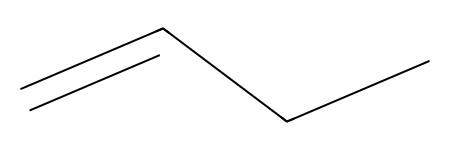

In [58]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Chem.MolFromSmiles('C=CCC')

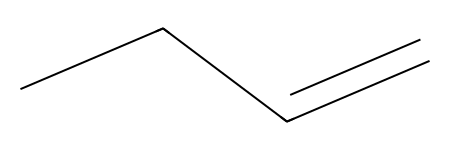

In [59]:
Chem.MolFromSmiles('CCC=C')

In [60]:
canonical_smiles(['C=CCC'])

['C=CCC']

In [61]:
canonical_smiles(['CCC=C'])

['C=CCC']

In [62]:
# Canonical SMILES
Canon_SMILES = canonical_smiles(dataset.SMILES)
len(Canon_SMILES)

92456

In [63]:
# Put the smiles in the dataframe
dataset['SMILES'] = Canon_SMILES
dataset

,SMILES,Column8
0,CC,0.269
1,CN,-4.686
2,CO,-2.865
3,CF,-1.005
4,FF,-0.191
...,...,...
92451,C#CC#CC#CC=CC#C,0.071
92452,N#CC#CC#CC#CC#N,-0.191
92453,C#CC#CC#CC#CC#N,0.071
92454,C#CC#CC#CC#CC#C,0.071


In [64]:
# Create a list for duplicate smiles
duplicates_smiles = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
len(duplicates_smiles)

0

In [66]:
# Create a list for duplicate smiles
dataset[dataset['SMILES'].isin(duplicates_smiles)].sort_values(by=['SMILES'])

,SMILES,Column8


## 2.  Drop duplicate values

In [67]:
dataset_new = dataset.drop_duplicates(subset=['SMILES'])
# len(dataset_new)

In [68]:
# dataset_new = dataset

## Calculate descriptors using RDkit

### a. General molecular descriptors-about 200 molecular descriptors

In [69]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(dataset_new['SMILES'])

In [70]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors.to_csv('output_file.csv', index=False)
# df_with_200_descriptors

### b. Fingerprints

In [21]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i) 
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)  
    return np.array(Morgan_fpts)

In [22]:
Morgan_fpts = morgan_fpts(dataset_new['SMILES'])
Morgan_fpts.shape

(2873, 2048)

In [23]:
Morgan_fingerprints = pd.DataFrame(Morgan_fpts,columns=['Col_{}'.format(i) for i in range(Morgan_fpts.shape[1])])
Morgan_fingerprints

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate descreptors using Mordred-1826 descriptors

In [24]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    return df

In [25]:
mordred_descriptors = All_Mordred_descriptors(dataset_new['SMILES'])

100%|██████████| 2873/2873 [01:01<00:00, 46.65it/s]


In [26]:
mordred_descriptors.shape

(2873, 1826)

In [27]:
mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,12.527341,2.311476,4.622953,12.527341,1.138849,3.302522,...,9.182249,41.326257,160.049985,8.891666,152,13,54.0,59.0,5.284722,2.333333
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,1,0,7.727407,1.931852,3.863703,7.727407,1.103915,2.752227,...,7.321850,31.336140,122.013457,8.715247,52,4,24.0,22.0,3.861111,1.833333
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,1,0,30.648742,2.324224,4.648448,30.648742,1.225950,4.118873,...,9.931735,59.295845,361.108086,8.024624,1882,35,124.0,139.0,9.729167,5.486111
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,10.792280,2.245827,4.491654,10.792280,1.199142,3.099448,...,8.806724,37.839725,160.979905,11.498565,84,10,42.0,46.0,4.083333,2.027778
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,12.133645,2.047810,4.095621,12.133645,1.103059,3.219224,...,8.131825,38.565088,156.151415,5.037142,194,9,42.0,41.0,5.472222,2.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,38.253985,2.374938,4.749876,38.253985,1.366214,4.258939,...,10.073357,62.971588,398.135324,7.656449,2014,41,142.0,164.0,6.166667,6.361111
2869,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,13.098358,2.369838,4.633950,13.098358,1.309836,3.261311,...,9.161465,53.745115,211.929533,14.128636,105,12,52.0,61.0,2.833333,2.222222
2870,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,22.978744,2.442763,4.885526,22.978744,1.276597,3.800055,...,9.763593,50.871918,247.120843,7.060596,574,28,88.0,103.0,6.055556,4.277778
2871,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,12.170709,2.322596,4.516123,12.170709,1.352301,3.160409,...,8.914761,51.887188,134.019021,8.934601,79,9,46.0,53.0,1.972222,2.027778
